In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from collections import deque
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import loadBar
from csv_parser import CSVParser
from globals import RESOURCE_FOLDER, STEPSIZES, OUTPUT_WINDOW, INPUT_WINDOW, OUTPUT_FORECAST, DELETEABLE_COLUMNS, ONE_HOT_COLUMNS
from feature_engineer import FeatureEngineer
from exploring_data_functions import *



In [46]:
parser = CSVParser(RESOURCE_FOLDER)
total_df = parser.retrieve_training_data()

In [47]:
total_df["time"] = pd.to_datetime(total_df['time'])

In [48]:
def map_indexes_within_timewindow(df, time_col, timewindow):

    index_map = {}    

    within_window = deque()
    

    for current_idx in range(len((df))):
        current_row = df.iloc[current_idx]
        current_time = current_row[time_col]
        

        while within_window and (current_time - within_window[0][1] > timewindow):
            index_map[within_window[0][0]] = within_window[-1][0]
            within_window.popleft()
        
        if current_idx == df.index[-1]:
            for idx, _ in within_window:
                index_map[idx] = current_idx
        

        within_window.append((current_idx, current_time))
    
    return index_map

In [49]:
def calculate_time_diffs_within_window(df, time_deltas=[]):
    result_list= []
    vessel_dfs = df.groupby('vesselId')
    j=0
    for _, vessel_df in vessel_dfs:
        j+=1
        loadBar.load_bar(len(vessel_dfs), j)
        
        vessel_df = vessel_df.sort_values(by='time')
        groups = vessel_df.groupby(pd.Grouper(key="time", freq='5D'))
        
        for _, group in groups:
                group_deltas=time_deltas.copy()
                if len(group) < 2:
                    continue
                while group_deltas and group.iloc[-1]['time']-group.iloc[0]['time'] < group_deltas[0]:
                    group_deltas.pop(0)
                feature_rows=[group.iloc[0]]

                for i in range(len(group)):
                    future_row = group.iloc[i]

                    for current_row in feature_rows:
                        new_row = current_row.copy()
                        new_row['next_latitude'] = future_row['latitude']
                        new_row['next_longitude'] = future_row['longitude']
                        new_row['time_diff'] = (future_row['time'] - current_row['time']).total_seconds()
                        result_list.append(new_row)

                    if group_deltas:
                        if group.iloc[-1]['time']-future_row['time'] < group_deltas[0]:
                            group_deltas.pop(0)
                            feature_rows.append(future_row)
                        
    print("Concating")
    result_df = pd.DataFrame(result_list)

    last_rows = df.groupby('vesselId').tail(1)

    last_rows = last_rows.reset_index(drop=True)
    result_df
    
    return result_df, last_rows

In [50]:
print(total_df)

                       time    cog   sog  rot  heading  navstat  latitude  \
0       2024-01-01 00:00:25  284.0   0.7    0       88        0 -34.74370   
1       2024-01-01 00:00:36  109.6   0.0   -6      347        1   8.89440   
2       2024-01-01 00:01:45  111.0  11.0    0      112        0  39.19065   
3       2024-01-01 00:03:11   96.4   0.0    0      142        1 -34.41189   
4       2024-01-01 00:03:51  214.0  19.7    0      215        0  35.88379   
...                     ...    ...   ...  ...      ...      ...       ...   
1520445 2024-05-07 23:59:07  359.1  13.4    0        1        0  52.19131   
1520446 2024-05-07 23:59:08   12.3  17.1    0       13        0  38.96142   
1520447 2024-05-07 23:59:08  269.8  14.9   -1      270        0  49.71372   
1520448 2024-05-07 23:59:08    8.0  18.7    0        6        0  38.27895   
1520449 2024-05-07 23:59:08  336.0  14.3    5      337        0  38.98635   

         longitude                   vesselId                    portId  ..

In [51]:
timedeltas=[timedelta(days=3),timedelta(days=1)]
total_df, last_rows = calculate_time_diffs_within_window(total_df, timedeltas) #1 min 14 sec on no delta, 2 min 30 sec on 1 and 3 day delta

KeyboardInterrupt: 

In [ ]:
print(total_df)

                   time    cog  sog  rot  heading  navstat  latitude  \
64  2024-01-01 00:14:36  348.0  0.0    0      333        5  51.30883   
64  2024-01-01 00:14:36  348.0  0.0    0      333        5  51.30883   
64  2024-01-01 00:14:36  348.0  0.0    0      333        5  51.30883   
64  2024-01-01 00:14:36  348.0  0.0    0      333        5  51.30883   
64  2024-01-01 00:14:36  348.0  0.0    0      333        5  51.30883   
..                  ...    ...  ...  ...      ...      ...       ...   
141 2024-01-01 00:16:21  345.0  0.0    0      345        5  54.37932   
141 2024-01-01 00:16:21  345.0  0.0    0      345        5  54.37932   
141 2024-01-01 00:16:21  345.0  0.0    0      345        5  54.37932   
141 2024-01-01 00:16:21  345.0  0.0    0      345        5  54.37932   
141 2024-01-01 00:16:21  345.0  0.0    0      345        5  54.37932   

     longitude                   vesselId                    portId  \
64     3.23027   61e9f38eb937134a3c4bfd8d  61d36f9a0a1807568ff9a

In [ ]:
feature_engineering_functions = [numerize_vesselId, numerize_portId, numerize_shippingLineId, 
                                 numerize_homePort, categorize_navstat, numerize_UN_LOCODE, 
                                 numerize_ISO, type_dummies, minutes_to_etaParsed] #, apply_markov,, categorize_rot



feature_engineer = FeatureEngineer(total_df)
feature_engineer.apply_features(feature_engineering_functions)
total_df = feature_engineer.get_dataframe()

total_df.set_index("time", inplace=True)

Applying categorize_navstat
Applying numerize_UN_LOCODE
Applying numerize_ISO
Applying type_dummies
Applying minutes_to_etaParsed
                       cog  sog  rot  heading  latitude  longitude  \
time                                                                 
2024-01-01 00:14:36  348.0  0.0    0      333  51.30883    3.23027   
2024-01-01 00:14:36  348.0  0.0    0      333  51.30883    3.23027   
2024-01-01 00:14:36  348.0  0.0    0      333  51.30883    3.23027   
2024-01-01 00:14:36  348.0  0.0    0      333  51.30883    3.23027   
2024-01-01 00:14:36  348.0  0.0    0      333  51.30883    3.23027   
...                    ...  ...  ...      ...       ...        ...   
2024-01-01 00:16:21  345.0  0.0    0      345  54.37932   18.65969   
2024-01-01 00:16:21  345.0  0.0    0      345  54.37932   18.65969   
2024-01-01 00:16:21  345.0  0.0    0      345  54.37932   18.65969   
2024-01-01 00:16:21  345.0  0.0    0      345  54.37932   18.65969   
2024-01-01 00:16:21  345.0  0.

In [ ]:
def replace_nan_with_zero(df):
    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if column contains NaN values
        if df[col].isna().any():
            # Drop NaNs temporarily to check the data types of the rest of the values
            non_na_values = df[col].dropna()
            # Check if all non-NaN values are either bool, float, or int
            if non_na_values.apply(lambda x: isinstance(x, (bool, int, float))).all():
                df[col].fillna(0, inplace=True)
    return df

total_df = replace_nan_with_zero(total_df)

In [ ]:

def remove_non_numeric_columns(df):
    # Select columns that are either of type bool, float, or int
    df = df.select_dtypes(include=['bool', 'float', 'int'])
    return df

total_df = remove_non_numeric_columns(total_df)


In [ ]:
print((total_df.columns))

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude',
       'portLongitude', 'portLatitude', 'next_latitude', 'next_longitude',
       'time_diff', 'UN_LOCODE_num', 'ISO_num'],
      dtype='object')


In [ ]:
def train_test_split(df_old, perc1, perc2):

    df = df_old.sample(frac=1).reset_index(drop=True)

    y_list = ['next_latitude', 'next_longitude'] #'next_latitude', 'next_longitude'
    ys = df[y_list]
    Xs = df.drop(columns = y_list)

    X_train = Xs.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    y_train = ys.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    X_val = Xs.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    y_val = ys.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    X_test = Xs.iloc[int(np.round(Xs.shape[0]*perc2)):,:]
    y_test = ys.iloc[int(np.round(Xs.shape[0]*perc2)):,:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(total_df, 0.85, 0.90)

In [ ]:
X_train_cols= X_train.columns

In [ ]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest_X = xgb.DMatrix(X_test)

params = {"objective": "reg:squarederror",
            "max_depth": 10, #7
            "booster": "gbtree",
            "tree-method": "gpu_hist",
            "colsample_bynode": 0.5, #0.4
            "num_parallel_tree": 30, #50
            "subsample": 0.7, #0.6
            "seed": 42,
            "learning_rate": 1,
            #"n_estimators": 100,
            #"reg_alpha": 0.1,
            #"reg_lambda": 0.1,
            #"n_jobs": -1,
            "verbosity": 1
            }

#Subsample was 0.8, num-parallel tree was 100, colsample-bynode was 0.5 and max-depth was 5. Before tuning. 

#After first round of tuning we got sumbsample was 0.6, num-parallel tree was 50, colsample-bynode was 0.4 and max-depth was 7. Before tuning. 

num_boost_round = 30

#Tried 50, but that stagnated quickly. So reducing again to 30.  


early_stopping_rounds = 3

print(dtrain)

model = xgb.train(params, dtrain, num_boost_round, evals=[(dval, "validation")], 
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=True)


preds = model.predict(dtest_X)

           cog   sog  rot  heading  navstat  latitude  longitude  \
0        128.1  13.9    2      130        0  39.24893   14.84582   
1        333.1   1.8    0      196        0 -26.30243  153.29050   
2        201.7   0.0    0       77        5 -27.44781  153.09581   
3        313.0  17.4    0      314        0  11.77978  101.23957   
4        338.8  16.4  -10      338        0  36.79964   21.58398   
...        ...   ...  ...      ...      ...       ...        ...   
1292377   24.1  13.5    0       25        0  54.51090   12.27081   
1292378  177.6  13.3    0      182        0  54.79259   10.86377   
1292379  302.5   0.0    0      131        5  55.85553   12.83279   
1292380  316.0   9.0    0      316        0  36.91642  -75.90893   
1292381  144.0  18.4    0      142        0 -20.11615    5.84657   

         portLongitude  portLatitude  time_diff  UN_LOCODE_num  ISO_num  
0            15.904444     38.456667    22461.0            317       38  
1           153.169444    -27.38250

In [ ]:
def calculate_time_diff_with_last_rows(test_df, last_rows):
    
    merged_df = pd.merge(
        test_df[["ID", "vesselId", "time"]],
        last_rows,
        on='vesselId',
        suffixes=('', '_last')
    )
    print(merged_df.columns)
    
    merged_df['time_diff'] = (merged_df['time'] - merged_df['time_last']).dt.total_seconds()
    
    merged_df = merged_df.drop(columns=[ 'time_last'])
    
    
    return merged_df

In [ ]:
test_df = parser.retrieve_test_data()

In [ ]:
print(test_df.head())

   ID                  vesselId                time  scaling_factor
0   0  61e9f3aeb937134a3c4bfe3d 2024-05-08 00:03:16             0.3
1   1  61e9f473b937134a3c4c02df 2024-05-08 00:06:17             0.3
2   2  61e9f469b937134a3c4c029b 2024-05-08 00:10:02             0.3
3   3  61e9f45bb937134a3c4c0221 2024-05-08 00:10:34             0.3
4   4  61e9f38eb937134a3c4bfd8d 2024-05-08 00:12:27             0.3


In [ ]:
#print(last_rows.columns)
"""
last_rows =last_rows[['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',
       'longitude', 'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 
       #'shippingLineId', 'CEU', 'DWT', 'GT',
       #'NT', 
       'vesselType', 
       #'breadth', 'depth', 'draft', 'enginePower',
       #'freshWater', 'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed',
       #'maxWidth', 'rampCapacity', 'yearBuilt
]]"""




"\nlast_rows =last_rows[['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',\n       'longitude', 'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',\n       'portLongitude', 'portLatitude', \n       #'shippingLineId', 'CEU', 'DWT', 'GT',\n       #'NT', \n       'vesselType', \n       #'breadth', 'depth', 'draft', 'enginePower',\n       #'freshWater', 'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed',\n       #'maxWidth', 'rampCapacity', 'yearBuilt\n]]"

In [ ]:
def split_dataframe(df):
    # Generate a unique ID for each row
    df['ID'] = range(1, len(df) + 1)
    
    # Create the first DataFrame with ID, predicted_latitude, and predicted_longitude
    df_predicted = df[['ID', 'latitude', 'longitude']].rename(columns={'latitude': 'predicted_latitude', 'longitude': 'predicted_longitude'})
    
    # Create the second DataFrame with ID, time, and vesselId
    df_info = df[['ID', 'time', 'vesselId']]
    
    return df_predicted, df_info

In [ ]:
test_df=calculate_time_diff_with_last_rows(test_df,last_rows)

Index(['ID', 'vesselId', 'time', 'time_last', 'cog', 'sog', 'rot', 'heading',
       'navstat', 'latitude', 'longitude', 'portId', 'etaParsed', 'UN_LOCODE',
       'ISO', 'portLongitude', 'portLatitude'],
      dtype='object')


In [ ]:
print(test_df.columns)

Index(['ID', 'vesselId', 'time', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 'time_diff'],
      dtype='object')


In [ ]:
feature_engineer = FeatureEngineer(test_df)
feature_engineer.apply_features(feature_engineering_functions)
test_df = feature_engineer.get_dataframe()

test_df.set_index("time", inplace=True)
test_df = remove_non_numeric_columns(test_df)





In [ ]:
#test_df.drop(columns="vesselType")

In [ ]:
def make_predictions(model, input_df):
    # Extract the features for prediction, excluding the 'ID' column
    features_df = input_df.drop(columns=['ID'])
    features_df = features_df[X_train_cols]
    # Generate predictions using the model
    predictions = model.predict(xgb.DMatrix(features_df))
    
    # Create a DataFrame with the predictions, renaming columns as required
    predictions_df = pd.DataFrame(predictions, columns=['next_latitude', 'next_longitude'])
    predictions_df = predictions_df.rename(columns={'next_latitude': 'latitude', 'next_longitude': 'longitude'})
    
    # Combine the 'ID' column with the predictions DataFrame
    result_df = pd.concat([input_df['ID'].reset_index(drop=True), predictions_df], axis=1)
    
    return result_df

In [ ]:
result_df = make_predictions(model, test_df)
result_fin = pd.DataFrame()
result_fin[["ID","longitude_predicted","latitude_predicted"]]=result_df[["ID","longitude","latitude"]]

In [ ]:
result_fin.to_csv(RESOURCE_FOLDER+"/result_simple.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

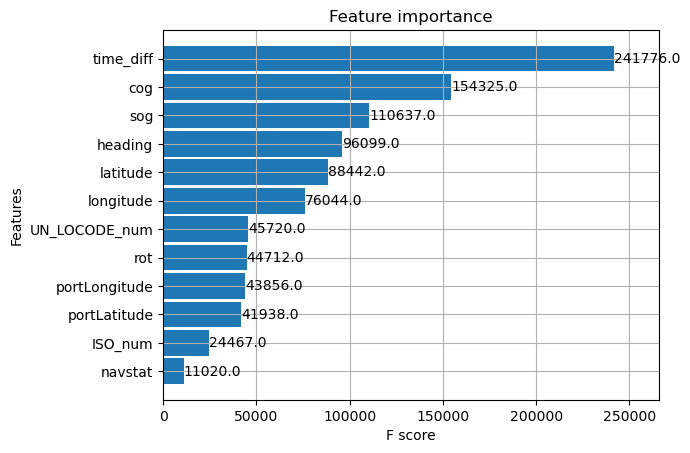

In [ ]:
plot_importance(model, height=0.9)

Mde 1
With stuff + prt crdinates

Mde 2
Vessetype nt imprtant 

Mde 3
Away with Minutes, hrs and day with tuned hyperparams